# **Training**

### **Libraries Used**

In [5]:
!pip install torch

  Using cached torch-2.9.1-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
Using cached torch-2.9.1-cp313-cp313-win_amd64.whl (110.9 MB)
Using cached fsspec-2025.10.0-py3-none-any.whl (200 kB)
Using cached networkx-3.6-py3-none-any.whl (2.1 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl

In [90]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

In [ ]:
import pandas as pd

df_clean = pd.read_csv("cleaned_patient_data.csv")
df_anon  = pd.read_csv("anonimized_patient_data.csv")

target = "HadHeartAttack"

cols_to_remove = [
    "TetanusStatus",
    "ECigaretteUsage",
    "RaceEthnicityCategory",
    "SmokerStatus_Current smoker - now smokes some days",
    "SmokerStatus_Current smoker - now smokes every day",
    "SmokerStatus_Former smoker"
]

df_clean = df_clean.drop(columns=cols_to_remove)
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.drop(target)



In [97]:
from imblearn.over_sampling import SMOTE

def split_data_resampled(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, shuffle=True
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


In [98]:
def plot_confusion_matrix(model, X_test, y_test, title="Confusion Matrix"):
    # Put model in evaluation mode
    model.eval()
    
    # Convert features to tensor
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Predictions
    with torch.no_grad():
        preds = model(X_test_t).numpy().flatten()
        
    preds = (preds > 0.5).astype(int)  # threshold
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, preds)
    
    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Covid (0)", "Covid Positive (1)"],
                yticklabels=["No Covid (0)", "Covid Positive (1)"])
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()



In [99]:
# ============================
# DATA LOADER
# ============================

def create_loader(X, y, batch_size=256):
    X_t = torch.tensor(X.values, dtype=torch.float32)
    y_t = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)


# ============================
# IMPROVED MLP ARCHITECTURE
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)   # logits → BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.model(x)


# ============================
# TRAINING LOOP WITH EARLY STOPPING
# ============================

def train_model(model, train_loader, val_loader, criterion, epochs=100, lr=0.001, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=3, factor=0.5
    )

    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.float()
            yb = yb.float()

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # ===== VALIDATION =====
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.float()
                yb = yb.float()
                logits = model(xb)
                val_loss += criterion(logits, yb).item()

        scheduler.step(val_loss)

        print(f"Epoch {epoch} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            best_state = model.state_dict().copy()
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_state)
    return model


# ============================
# EVALUATION
# ============================

def evaluate_model(model, X_test, y_test):
    model.eval()
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)

    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).numpy().flatten()
        preds = (probs > 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    pre = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1  = f1_score(y_test, preds, zero_division=0)

    return acc, pre, rec, f1, preds


# ============================
# SPLITTING
# ============================



In [100]:

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df_clean.drop(target, axis=1), df_clean[target])
X_train, X_val, X_test, y_train, y_val, y_test = split_data_resampled(X_res, y_res)

# Compute class weight
pos_weight_value = (len(y_train) - y_train.sum()) / y_train.sum()
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# Data Loaders
train_loader = create_loader(X_train, y_train)
val_loader   = create_loader(X_val, y_val)

# Model
model_clean = MLP(input_dim=X_train.shape[1])

# Train — MUST PASS criterion ⚠️
model_clean = train_model(
    model_clean,
    train_loader,
    val_loader,
    criterion=criterion
)


Epoch 0 | Train Loss: 489.5195 | Val Loss: 99.8265
Epoch 1 | Train Loss: 471.4270 | Val Loss: 99.5834
Epoch 2 | Train Loss: 466.2396 | Val Loss: 97.6583
Epoch 3 | Train Loss: 460.9938 | Val Loss: 96.9067
Epoch 4 | Train Loss: 457.5718 | Val Loss: 96.4698
Epoch 5 | Train Loss: 453.4981 | Val Loss: 95.3589
Epoch 6 | Train Loss: 450.9513 | Val Loss: 95.0057
Epoch 7 | Train Loss: 447.4350 | Val Loss: 94.0477
Epoch 8 | Train Loss: 444.6312 | Val Loss: 95.3195
Epoch 9 | Train Loss: 440.9911 | Val Loss: 92.6257
Epoch 10 | Train Loss: 438.7070 | Val Loss: 93.2180
Epoch 11 | Train Loss: 436.6204 | Val Loss: 90.7308
Epoch 12 | Train Loss: 434.3291 | Val Loss: 90.7309
Epoch 13 | Train Loss: 432.5879 | Val Loss: 89.7915
Epoch 14 | Train Loss: 430.1830 | Val Loss: 90.6349
Epoch 15 | Train Loss: 427.4139 | Val Loss: 89.9868
Epoch 16 | Train Loss: 426.5934 | Val Loss: 88.6509
Epoch 17 | Train Loss: 425.6256 | Val Loss: 88.9807
Epoch 18 | Train Loss: 423.7909 | Val Loss: 87.6713
Epoch 19 | Train Loss:

In [101]:


clean_acc, clean_pre, clean_rec, clean_f1, preds = evaluate_model(model_clean, X_test, y_test)

print("=== Clean Dataset Metrics ===")
print(f"Accuracy:  {clean_acc:.4f}")
print(f"Precision: {clean_pre:.4f}")
print(f"Recall:    {clean_rec:.4f}")
print(f"F1-score:  {clean_f1:.4f}")



=== Clean Dataset Metrics ===
Accuracy:  0.8827
Precision: 0.8562
Recall:    0.9185
F1-score:  0.8863


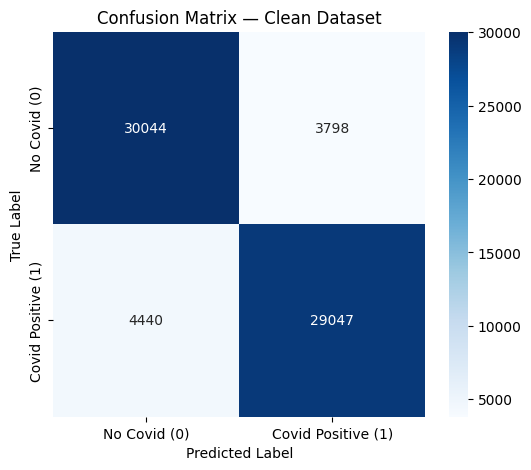

In [102]:
plot_confusion_matrix(model_clean, X_test, y_test, 
                      title="Confusion Matrix — Clean Dataset")


### **Anonimo**

In [103]:

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res1, y_res1 = sm.fit_resample(df_anon.drop(target, axis=1), df_anon[target])
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = split_data_resampled(X_res1, y_res1)

# Compute class weight
pos_weight_value = (len(y_train1) - y_train1.sum()) / y_train1.sum()
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# Data Loaders
train_loader = create_loader(X_train1, y_train1)
val_loader   = create_loader(X_val1, y_val1)

# Model
model_anon = MLP(input_dim=X_train1.shape[1])

# Train — MUST PASS criterion ⚠️
model_anon = train_model(
    model_anon,
    train_loader,
    val_loader,
    criterion=criterion
)


Epoch 0 | Train Loss: 372.0377 | Val Loss: 70.5055
Epoch 1 | Train Loss: 336.0668 | Val Loss: 69.2365
Epoch 2 | Train Loss: 328.6073 | Val Loss: 74.7337
Epoch 3 | Train Loss: 323.4065 | Val Loss: 70.0085
Epoch 4 | Train Loss: 318.9013 | Val Loss: 68.5588
Epoch 5 | Train Loss: 317.0367 | Val Loss: 75.5039
Epoch 6 | Train Loss: 313.9780 | Val Loss: 70.9672
Epoch 7 | Train Loss: 311.5388 | Val Loss: 66.6250
Epoch 8 | Train Loss: 310.1195 | Val Loss: 66.5049
Epoch 9 | Train Loss: 307.8068 | Val Loss: 79.2859
Epoch 10 | Train Loss: 305.1790 | Val Loss: 66.3332
Epoch 11 | Train Loss: 304.0126 | Val Loss: 65.5343
Epoch 12 | Train Loss: 302.3445 | Val Loss: 67.9095
Epoch 13 | Train Loss: 300.8464 | Val Loss: 63.9131
Epoch 14 | Train Loss: 298.8865 | Val Loss: 65.0778
Epoch 15 | Train Loss: 298.1355 | Val Loss: 72.4947
Epoch 16 | Train Loss: 295.9331 | Val Loss: 62.9501
Epoch 17 | Train Loss: 294.2328 | Val Loss: 63.0950
Epoch 18 | Train Loss: 292.6814 | Val Loss: 71.6512
Epoch 19 | Train Loss:

In [104]:
anon_acc, anon_pre, anon_rec, anon_f1, preds = evaluate_model(model_anon, X_test1, y_test1)

print("=== Clean Dataset Metrics ===")
print(f"Accuracy:  {anon_acc:.4f}")
print(f"Precision: {anon_pre:.4f}")
print(f"Recall:    {anon_rec:.4f}")
print(f"F1-score:  {anon_f1:.4f}")

=== Clean Dataset Metrics ===
Accuracy:  0.9261
Precision: 0.9130
Recall:    0.9411
F1-score:  0.9268


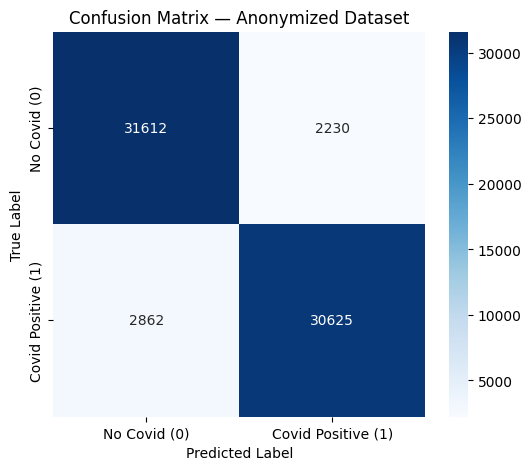

In [105]:
plot_confusion_matrix(model_anon, X_test1, y_test1, 
                      title="Confusion Matrix — Anonymized Dataset")
